# Coresets with DPPs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import sys
sys.path.append("DPPcoresets/src/")
from utils import set_plotting_options
set_plotting_options(usetex=True, font_size=14)

## k-means

### Data generation

drawn lengths are: 1024, 1022, 1017, 1023, 1023, 1023, 

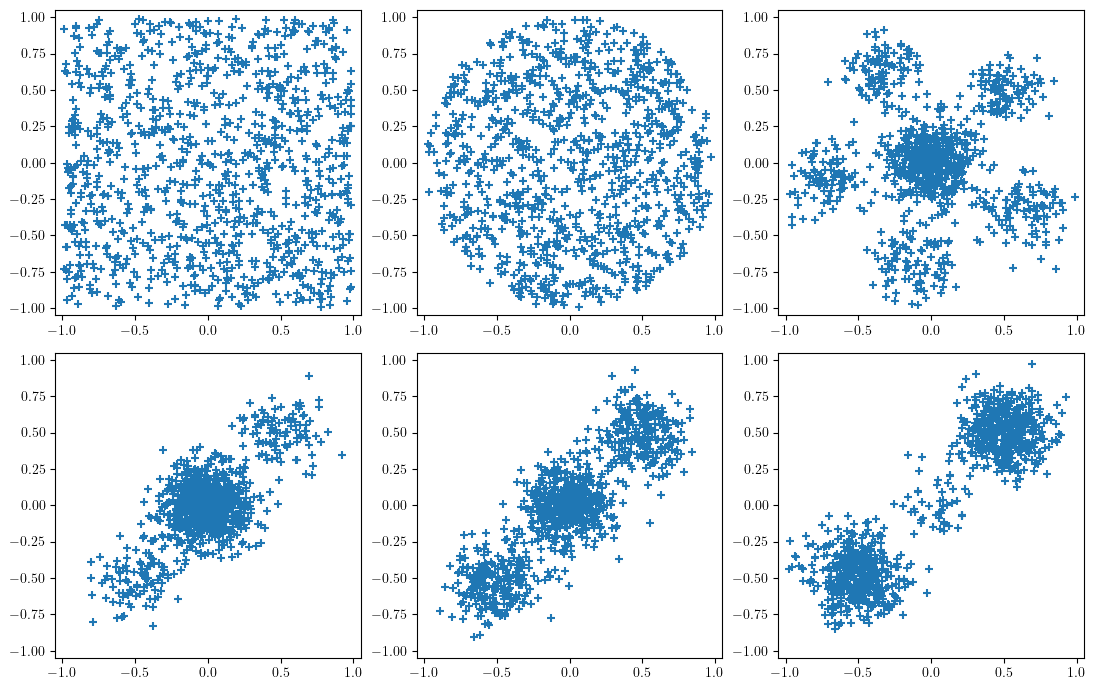

In [52]:
from utils import get_hypercube_data, get_circle_data, get_disk_data, get_corner_data

def draw_data(desired_n, d, k, prop_outliers=5/100, border=0.99):
    # Generate data
    radius_corner = 0.5*2**.5
    X_uniform = get_hypercube_data(desired_n, d, border=border)
    # X_corner = get_corner_data(desired_n, d, k, border=border)
    X_disk = get_disk_data(desired_n, d, radius=1)
    X_kcent_knonout = get_circle_data(desired_n, d, k, border=border)
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 2, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_2nonout = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*(1-k*prop_outliers), d, k, 1, border=border)
    X2 = get_circle_data(desired_n*k*prop_outliers, d, k, border=border)
    X_kcent_1nonout = np.concatenate((X1, X2))
    X2 = get_circle_data(desired_n*(1-2*prop_outliers), d, 2, 1, border=border)
    X1 = get_circle_data(desired_n*2*prop_outliers, d, 2, border=border)
    X_outlier = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n/2, d, 5, border=border)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    X_5subbubbles = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*20/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n*80/100, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_1 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n/2, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_2 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*95/100, d, 2, radius=radius_corner, variance=1/49, border=.99)
    X2 = get_circle_data(desired_n*5/100, d, 1, radius=0, variance=1/49, border=.99)
    X_2vs1_3 = np.concatenate((X1, X2))
    Xs = [X_uniform, X_disk, X_5subbubbles, X_2vs1_1, X_2vs1_2, X_2vs1_3]
    # Xs = [X_uniform, X_disk, X_outlier, X_kcent_knonout, X_kcent_2nonout, X_kcent_1nonout]
    print("drawn lengths are:", end=" ")
    for dataset in Xs:
        print(len(dataset), end=", ")
    return Xs

# plot
desired_n, d, k = 1024, 2, 3
Xs = draw_data(desired_n, d, k)
xylim = 1.05
plt.figure(figsize=(11,7)) # (12,5.5)
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(2,int(np.ceil(len(Xs)/2)),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+")
plt.tight_layout(), plt.show();

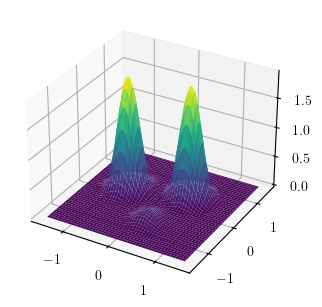

In [153]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# Compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(Xs[4])
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)
plt.show();

### Sensitivity

In [154]:
from utils import get_true_sensit

# Draw data with less datapoints because of latency 
desired_n, d, k = 100, 2, 3
Xs = draw_data(desired_n, d, k)
Xs = np.array(Xs, dtype=object)[[0,2,3,4]]

# Compute and plot sensitivity
sensits = []
for i_plot, X_plot in enumerate(Xs):
    sensits.append(get_true_sensit(X_plot, k))

drawn lengths are: 100, 97, 100, 98, 98, 100, 

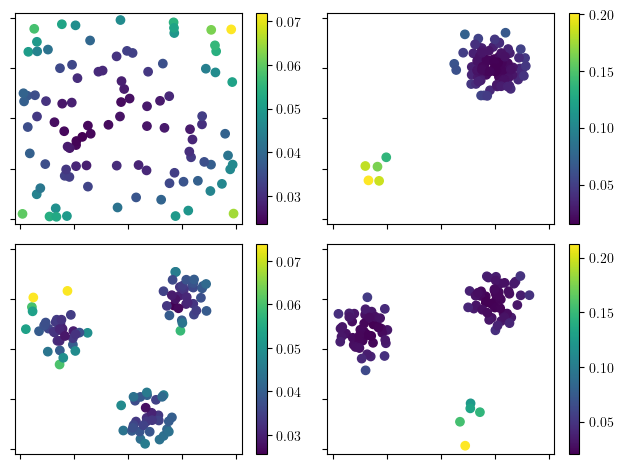

In [155]:
def my_plot():
    for i_plot, X_plot in enumerate(Xs):
        sensit = sensits[i_plot]
        plt.subplot(2,round(len(Xs)/2),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
        plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
        plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
my_plot()
plt.tight_layout()
plt.show()

### Sampling example

obtained n=300
/!\ OPE sampling and gamma_X is None
it will be KDE estimated, inducing n^2 complexity


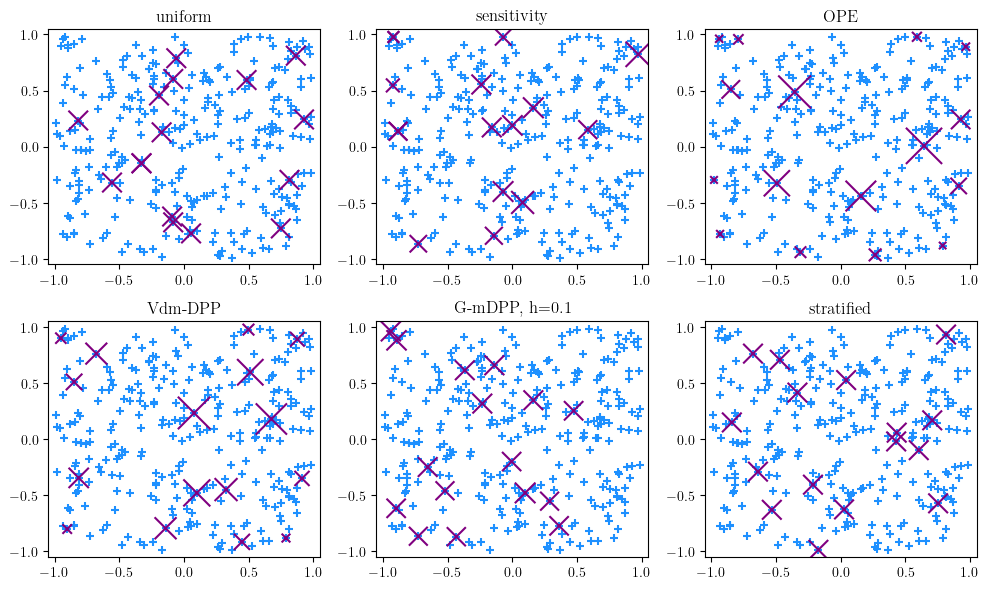

In [4]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# Generate data
d, desired_n, m, k = 2, 300, 16, 5
n_samples = 1
radius_corner = 0.5*2**.5
X = get_hypercube_data(desired_n, d, border=.99)
n = len(X)
print(f"obtained {n=}")

# Sample
samples_weights_list = []
samples_weights_list.append( draw_uniform(X, m, n_samples) )
samples_weights_list.append( draw_sensitivity(X, m, n_samples, k, delta=.1) )
samples_weights_list.append( draw_OPE(X, m, n_samples, prop_uniform=0) )
samples_weights_list.append( draw_discrete_OPE(X, m, n_samples) )
samples_weights_list.append( draw_gaussian_kDPP(X, m, n_samples, bandwidth=.1) )
samples_weights_list.append( draw_stratified(X, m, n_samples) )

# Plot
titles = ["uniform","sensitivity","OPE","Vdm-DPP","G-kDPP, h=0.1","stratified"]
plt.figure(figsize=(10,6))
for k, (samples, weights) in enumerate(samples_weights_list):
    X_samples = X[samples]
    xylim = 1.05
    plt.subplot(2,len(titles)//2+len(titles)%2,k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+', alpha=.5, color="dodgerblue")
    for i_sample in range(n_samples):
        weight = None
        if weights is not None: 
            weight = 200*m*weights[i_sample]
        else: 
            weight = 200*m*np.ones(m)/m
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight, color="purple")
    plt.title(titles[k])
plt.tight_layout(), 
# plt.savefig("samplers_example.pdf")
plt.show();

### Statistics

In [174]:
# Function for estimating the Jacobi parameters
def generate_Jacobi_parameters(X):
    mu1 = X.mean(axis=0)
    Xs = X * X
    mu2 = Xs.mean(axis=0)
    tmp = (mu1 + 1) / 2 + (mu2 - 1) / 4 - (mu1 + 1) * (mu1 + 1) / 4
    t = (1 - mu1) / 2 * ((1 + mu1) * (1 - mu1) / 4 / tmp - 1)
    a = t - 1
    b = (1 + mu1) / (1 - mu1) * t - 1
    jac_params = np.column_stack((a,b))
    jac_params = np.minimum(np.maximum(jac_params,-0.5),0.5)
    print('Estimated beta distribution parameter is\n', jac_params)
    return jac_params 

X = 2 * np.random.rand(10000, 2) -1
generate_Jacobi_parameters(X)

Estimated beta distribution parameter is
 [[-0.00102353 -0.00174543]
 [ 0.00785262 -0.00515963]]


array([[-0.00102353, -0.00174543],
       [ 0.00785262, -0.00515963]])

df. databases [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/), [Clustering basic benchmark](https://cs.joensuu.fi/sipu/datasets/)

In [170]:
from sklearn.datasets import load_digits
k, d = 10, 2
digits = load_digits(n_class=k)
X, y = digits['data'], digits['target']

from sklearn.decomposition import PCA
X = PCA(n_components=d).fit_transform(X)
thrs = 0.01
low, high = np.quantile(X, thrs, 0),  np.quantile(X, 1-thrs, 0)
sli_tail = np.all(low <= X, 1) & np.all(X <= high, 1)
X = X[sli_tail]
y = y[sli_tail]
X = 0.99 * (2 * (X - X.min(0)) / (X.max(0) - X.min(0)) - 1)

X.shape, y.shape, X.min(0), X.max(0)

((9600, 2), (768,), array([-0.99, -0.99]), array([0.99, 0.99]))

In [171]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
from sklearn.neighbors import KernelDensity

# # Data parameters, when experimenting on synthetic data
# d, desired_n, k = 2, 2**10, 3    # 2, 1024, 3
# # Draw data
# Xs = draw_data(desired_n, d, k)
# X_names = ["X_uniform", "X_disk", "X_outlier", "X_kcent_knonout", "X_kcent_2nonout", "X_kcent_1nonout"]
# i_dataset = 3 # choose the dataset index. 0 for uniform dataset.
# X, X_name = Xs[i_dataset], X_names[i_dataset]

print(f"experimenting on {X.shape} dataset")
n = len(X)
print(f"obtained {n=}")

# Repetitions parameters
n_queries, n_rep = 150, 150
ms = np.arange(1, 17, dtype=int)**2 # (1,14)
print(f"m list={ms}")
bandwidths = [.01, .05, .10, .20, .30] # for uniform dataset
# prop_uniforms = [1., 0.5, 0.25, 0.12, 0.] # for uniform dataset

from utils import pickle_dump, pickle_load
save_dir = "./"
save_path = save_dir + f"X_real_n{n}_m{ms[-1]}_3means_quer{n_queries}_rep{n_rep}.p"


# Init OPE sampler by pre-computing KDE on data
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
SE_means, SE_stds, relerrs = [], [], []

# Init queries
queries = X[np.random.choice(n, (n_queries,k), replace=False)] # np.zeros((1,1,X.shape[-1]))

ab_coeff = generate_Jacobi_parameters(X)
# ab_coeff = np.zeros_like(ab_coeff)
print(ab_coeff)
# Just draw from OPE to test and show in scatter plot
OPE_samples, OPE_weights = draw_OPE(X, ms[-1], 1, gamma_X=kde_distr)

experimenting on (9600, 2) dataset
obtained n=9600
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169 196 225 256]
Estimated beta distribution parameter is
 [[1.65019611 0.57189344]
 [0.83826205 0.85581811]]
[[1.65019611 0.57189344]
 [0.83826205 0.85581811]]


In [172]:
loss_Xs = []
for query in queries:
    # Evaluate the population loss
    loss_Xs.append(loss(X, query))
    
for m in ms:
    print(f"{m=}")
    # Sample
    samples_weights_list = []

    # Draw from samplers when experimenting for any datasets
    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )
    samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0.1) )
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
    # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )

    # # Draw from samplers when experimenting on uniform dataset only
    # if i_dataset==0:
    #     print("drawing from samplers conveived for experimenting on uniform dataset only")
    #     samples_weights_list.append( draw_stratified(X, m, n_rep) )
    #     for bandwidth in bandwidths:
    #         samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )
    #     # for prop_uniform in prop_uniforms:
    #     #     samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
        
    # Compute metrics for all samplers
    loss_samples = []
    for samples, weights in samples_weights_list:

        for loss_X, query in zip(loss_Xs, queries):
            # Evaluate the sample loss
            loss_samples = loss(X, query, samples, weights)

            # Compute metrics
            SEs = (loss_samples - loss_X)**2
            SE_means.append(SEs.mean(-1))
            SE_stds.append(SEs.std(-1))
            relerrs.append(relative_error(loss_samples, loss_X))

# Aggregate metrics
n_ms, n_samplers = len(ms), len(samples_weights_list)
relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
SE_means_argmax = SE_means.argmax(2) # argmax on queries
arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

pickle_dump([relerrs_sup, SE_means_sup, SE_stds_sup], save_path)

m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
m=196
m=225
m=256


./X_real_n9600_m256_3means_quer150_rep150.p


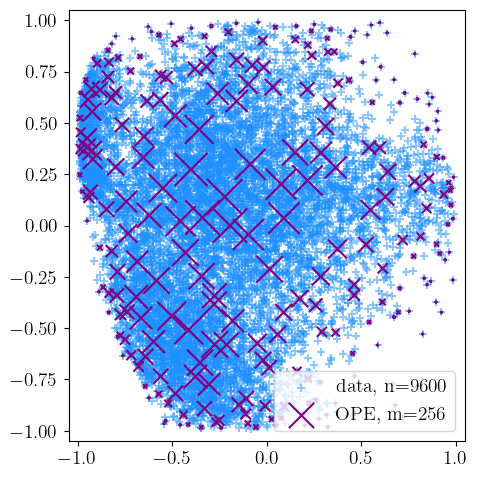

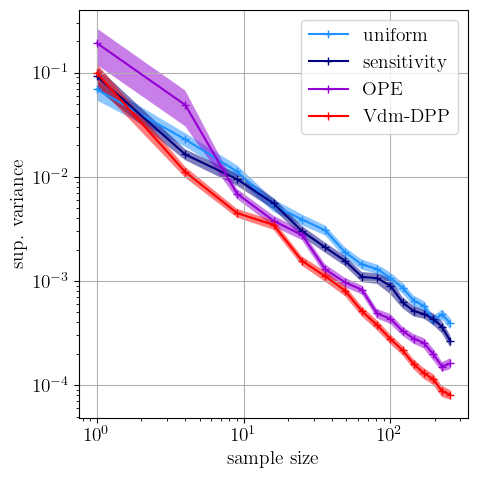

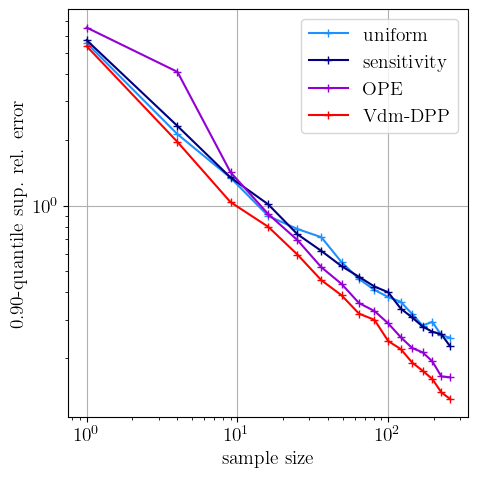

In [173]:
relerrs_sup, SE_means_sup, SE_stds_sup, = pickle_load(save_path)
prefix = f"mnist_k{k}_d{d}"

def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.figure(figsize=(5,5))
    plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}", alpha=0.5, color='dodgerblue')
    X_samples, X_weights = X[OPE_samples[0]], 100*ms[-1]*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, m={ms[-1]}", color='purple', s=X_weights)
    plt.legend(), plt.tight_layout()
    plt.savefig(prefix+"_OPE.pdf")


    plt.figure(figsize=(5,5))
    # Draw from samplers, experimenting for any datasets
    legends = ["uniform","sensitivity","OPE","Vdm-DPP","G-kDPP, h=0.1"][:-1]
    selector = range(len(legends))

    # # # Draw from samplers, experimenting on uniform dataset only
    # if i_dataset==0:
    #     legends += ["stratified"]
    #     legends += [f"G-kDPP, h={bandwidth:.2f}" for bandwidth in bandwidths]
    # #     legends += [f"prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
    #     # selector_uniform_samplers = [0,1,2,3,4,5]
    #     selector_uniform_samplers = [0,1,2,3,4,5]
    #     selector_uniform_gkdpp = [0,6,7,8,9,10]
    # #     selector_uniform_propunif = [11,12,13,14,15]
    # #     ##### choose one selector #####
    #     selector = selector_uniform_samplers
    #     # selector = selector_uniform_gkdpp
    # #     # selector = selector_uniform_propunif
    #     legends = np.array(legends)[selector]
    
    colors = ["dodgerblue","navy","darkviolet","red","orange","maroon"]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup[:,selector], label=legends, marker="+")
    for k in selector:
        plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid(), plt.tight_layout()
    plt.savefig(prefix+"_var.pdf")

    plt.figure(figsize=(5,5))
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(), plt.tight_layout()
    plt.savefig(prefix+"_relerr.pdf")

my_plot()
plt.tight_layout()
plt.show()